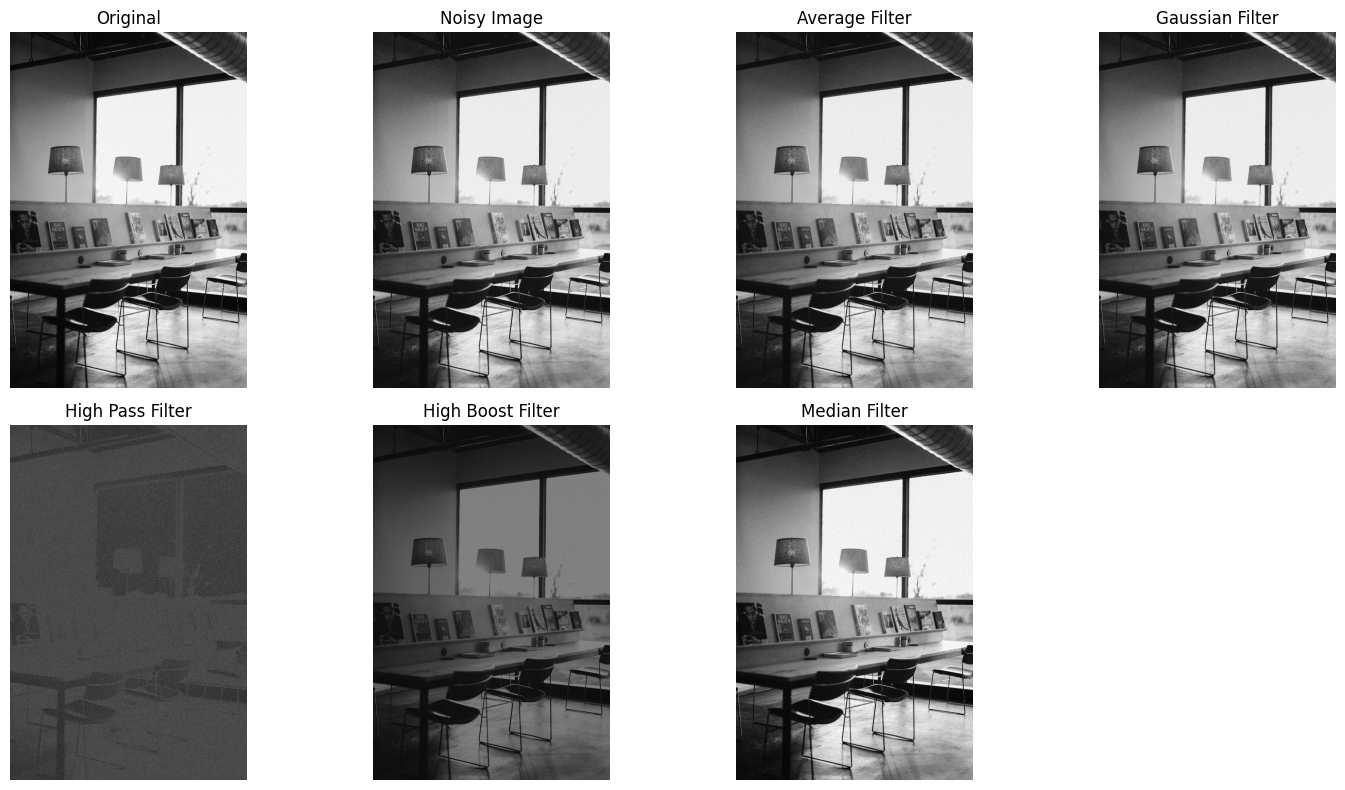

In [2]:
# question 1(average,gausian,high pass filter,high boost filter,median filter)
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read and prepare the image
image = cv2.imread(r"C:\Users\muska\Downloads\image1.jpg", cv2.IMREAD_GRAYSCALE)  # Read as grayscale
if image is None:
    raise ValueError("Image not found. Please check path.")

# Step 2: Add Gaussian noise for testing
noise = np.random.normal(0, 25, image.shape)  # mean=0, std=25
noisy_img = np.clip(image + noise, 0, 255).astype(np.uint8)

# I. Average Filter
average_filtered = cv2.blur(noisy_img, (3, 3))  # 3x3 averaging kernel

# II. Gaussian Filter
gaussian_filtered = cv2.GaussianBlur(noisy_img, (3, 3), sigmaX=1)

# III. High Pass Filter (edge enhancement)
# A typical 3x3 high-pass kernel
high_pass_kernel = np.array([[-1, -1, -1],
                             [-1,  8, -1],
                             [-1, -1, -1]])
high_pass_filtered = cv2.filter2D(noisy_img, -1, high_pass_kernel)

# IV. High Boost Filter
A = 1.5  # Boosting factor (>1)
# First get a blurred (low-pass) version
low_pass = cv2.GaussianBlur(noisy_img, (3, 3), sigmaX=1)
# High-boost = A*f(x,y) - LPF(f(x,y))
high_boost_filtered = cv2.addWeighted(noisy_img, A, low_pass, -1, 0)

# V. Median Filter
median_filtered = cv2.medianBlur(noisy_img, 3)

# Step 3: Display results
titles = ['Original', 'Noisy Image', 'Average Filter', 'Gaussian Filter',
          'High Pass Filter', 'High Boost Filter', 'Median Filter']
images = [image, noisy_img, average_filtered, gaussian_filtered,
          high_pass_filtered, high_boost_filtered, median_filtered]

plt.figure(figsize=(15, 8))
for i in range(7):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


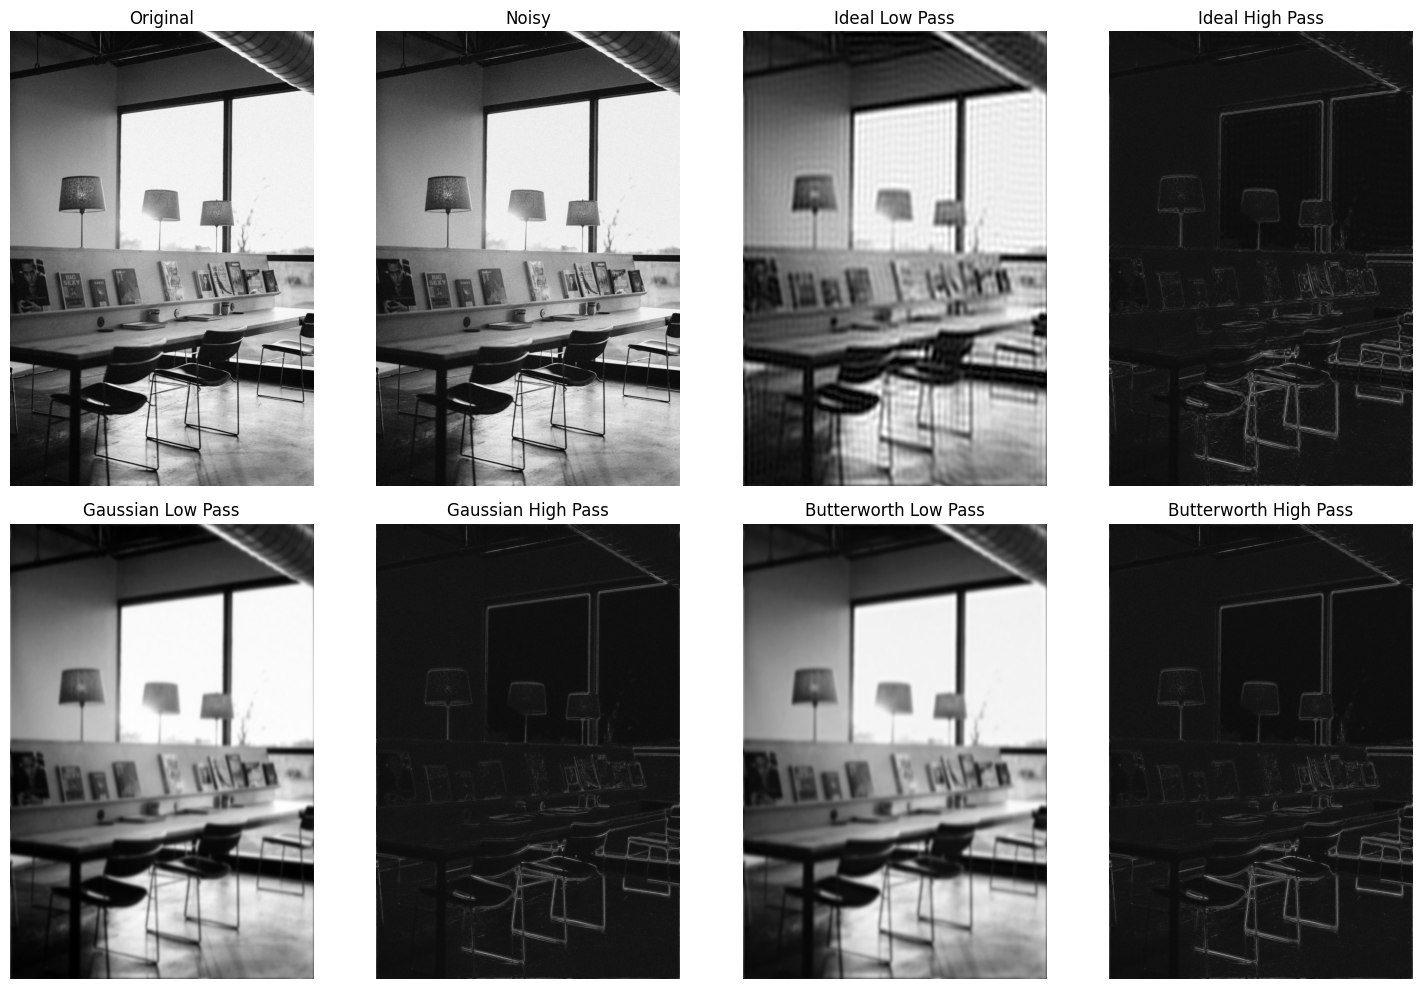

In [4]:
# question 2(ideal low pass and high pass)
# gausian low pass and high pass)
# butterworth low pass and hyigh pass
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read image and convert to grayscale
image = cv2.imread(r"C:\Users\muska\Downloads\image1.jpg", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Please check the path.")

# Add Gaussian noise to simulate noisy input
noise = np.random.normal(0, 20, image.shape)
noisy_img = np.clip(image + noise, 0, 255).astype(np.uint8)

# Step 2: Compute DFT (Fourier Transform)
dft = np.fft.fft2(noisy_img)
dft_shift = np.fft.fftshift(dft)  # Shift low frequencies to center

# Image dimensions
rows, cols = noisy_img.shape
crow, ccol = rows // 2, cols // 2

# Step 3: Create frequency domain filters
def ideal_low_pass(d, cutoff):
    mask = np.zeros((rows, cols), np.uint8)
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - crow)**2 + (j - ccol)**2) <= cutoff:
                mask[i, j] = 1
    return mask

def ideal_high_pass(d, cutoff):
    return 1 - ideal_low_pass(d, cutoff)

def gaussian_low_pass(d, cutoff):
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    dist = np.sqrt((x - ccol)**2 + (y - crow)**2)
    return np.exp(-(dist**2) / (2 * (cutoff**2)))

def gaussian_high_pass(d, cutoff):
    return 1 - gaussian_low_pass(d, cutoff)

def butterworth_low_pass(d, cutoff, order=2):
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    dist = np.sqrt((x - ccol)**2 + (y - crow)**2)
    return 1 / (1 + (dist / cutoff)**(2 * order))

def butterworth_high_pass(d, cutoff, order=2):
    return 1 - butterworth_low_pass(d, cutoff, order)

# Step 4: Apply filters (cutoff frequency = 50)
D0 = 50
ideal_LPF = ideal_low_pass(dft_shift, D0)
ideal_HPF = ideal_high_pass(dft_shift, D0)
gauss_LPF = gaussian_low_pass(dft_shift, D0)
gauss_HPF = gaussian_high_pass(dft_shift, D0)
butter_LPF = butterworth_low_pass(dft_shift, D0)
butter_HPF = butterworth_high_pass(dft_shift, D0)

# Step 5: Filtered images reconstruction
def apply_filter(filter_mask):
    filtered = dft_shift * filter_mask
    img_back = np.fft.ifftshift(filtered)
    img_back = np.fft.ifft2(img_back)
    img_back = np.abs(img_back)
    return np.uint8(np.clip(img_back, 0, 255))

ideal_low = apply_filter(ideal_LPF)
ideal_high = apply_filter(ideal_HPF)
gauss_low = apply_filter(gauss_LPF)
gauss_high = apply_filter(gauss_HPF)
butter_low = apply_filter(butter_LPF)
butter_high = apply_filter(butter_HPF)

# Step 6: Display results
titles = [
    'Original', 'Noisy',
    'Ideal Low Pass', 'Ideal High Pass',
    'Gaussian Low Pass', 'Gaussian High Pass',
    'Butterworth Low Pass', 'Butterworth High Pass'
]

images = [
    image, noisy_img,
    ideal_low, ideal_high,
    gauss_low, gauss_high,
    butter_low, butter_high
]

plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


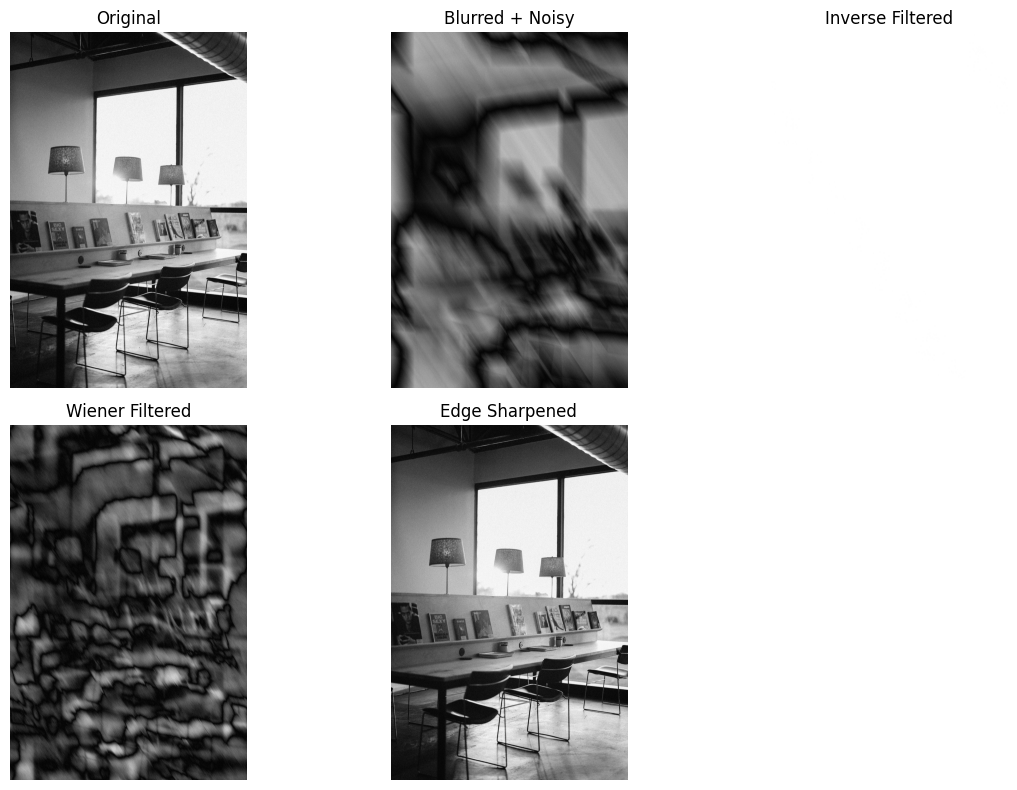

In [5]:
# question 3
# inverse and wiener filtering operation on a noisy image.
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read grayscale image
image = cv2.imread(r"C:\Users\muska\Downloads\image1.jpg", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Please check the path.")

# Step 2: Simulate motion blur (degradation function)
def motion_blur_psf(shape, a=0.1, b=0.1, T=1):
    """Creates motion blur transfer function H(u,v)"""
    M, N = shape
    u, v = np.meshgrid(np.arange(N), np.arange(M))
    u = u - N/2
    v = v - M/2
    pi = np.pi
    eps = 1e-8
    H = (T * np.sin(pi*(u*a + v*b)) * np.exp(-1j*pi*(u*a + v*b))) / (pi*(u*a + v*b) + eps)
    return np.fft.fftshift(H)

# Create degradation function
H = motion_blur_psf(image.shape)

# Step 3: Blur and add noise to the image
f = np.fft.fft2(image)
blurred = np.fft.ifft2(f * H)
blurred = np.abs(blurred)
noise = np.random.normal(0, 10, image.shape)
noisy = np.clip(blurred + noise, 0, 255).astype(np.uint8)

# Step 4: Inverse Filtering
H_mag = np.abs(H)
eps = 1e-3  # prevent division by zero
inv_filtered = np.fft.ifft2(np.fft.fft2(noisy) / (H + eps))
inv_filtered = np.abs(inv_filtered)
inv_filtered = np.clip(inv_filtered, 0, 255).astype(np.uint8)

# Step 5: Wiener Filtering
K = 0.01  # noise-to-signal ratio (adjust experimentally)
H_conj = np.conj(H)
wiener_filter = (H_conj / (H_mag**2 + K))
wiener_result = np.fft.ifft2(np.fft.fft2(noisy) * wiener_filter)
wiener_result = np.abs(wiener_result)
wiener_result = np.clip(wiener_result, 0, 255).astype(np.uint8)






# question 4 edge sharpening




# Step 6: Edge Sharpening (Spatial Domain)
# Using Laplacian sharpening
laplacian = cv2.Laplacian(image, cv2.CV_64F)
sharp = cv2.convertScaleAbs(image - 0.5 * laplacian)

# Step 7: Display Results
titles = ['Original', 'Blurred + Noisy', 'Inverse Filtered', 'Wiener Filtered', 'Edge Sharpened']
images = [image, noisy, inv_filtered, wiener_result, sharp]

plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
